In [1]:
import numpy as np
import pennylane as qml
import scipy.linalg
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

# Define QAOA ansatz
def qaoa_ansatz(params, edges, qubo_embedding=False):
    n_qubits = len(set(sum(edges, ())))  # Number of unique qubits in the problem
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    for layer in range(len(params) // 2):
        gamma, beta = params[2 * layer], params[2 * layer + 1]
        
        if qubo_embedding:
            for (i, j, w) in edges:  # Weighted QUBO embedding
                qml.CNOT(wires=[i, j])
                qml.RZ(2 * gamma * w, wires=j)
                qml.CNOT(wires=[i, j])
        else:
            for (i, j, _) in edges:
                qml.CNOT(wires=[i, j])
                qml.RZ(2 * gamma, wires=j)
                qml.CNOT(wires=[i, j])

        for i in range(n_qubits):
            qml.RX(2 * beta, wires=i)

# Setup QAOA circuits
n_qubits = 4
edges = [(0, 1, 1.5), (1, 2, 2.0), (2, 3, 1.0), (3, 0, 1.2)]  # Weighted graph for QUBO

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def get_qaoa_state(params, qubo_embedding=False):
    qaoa_ansatz(params, edges, qubo_embedding=qubo_embedding)
    return qml.state()

# Generate random parameters
num_layers = 3
params = np.random.uniform(0, np.pi, size=(2 * num_layers,))

# Compute states
state_qaoa_standard = get_qaoa_state(params, qubo_embedding=False)
state_qaoa_qubo = get_qaoa_state(params, qubo_embedding=True)

# Hilbert-Schmidt Test
def hilbert_schmidt_distance(state1, state2):
    rho1 = np.outer(state1, np.conj(state1))
    rho2 = np.outer(state2, np.conj(state2))
    return np.trace(scipy.linalg.sqrtm(rho1) @ rho2 @ scipy.linalg.sqrtm(rho1))

hst_value = hilbert_schmidt_distance(state_qaoa_standard, state_qaoa_qubo)

# Rényi-2 Entropy Calculation
def renyi_entropy(state):
    rho = np.outer(state, np.conj(state))
    rho_squared = rho @ rho
    return -np.log2(np.trace(rho_squared))

ree_standard = renyi_entropy(state_qaoa_standard)
ree_qubo = renyi_entropy(state_qaoa_qubo)

# Compare results
metrics = {
    "Hilbert-Schmidt Test": hst_value,
    "Rényi-2 Entropy (Standard QAOA)": ree_standard,
    "Rényi-2 Entropy (QUBO Embedded QAOA)": ree_qubo
}

# Display results
import pandas as pd
df = pd.DataFrame(metrics, index=["Value"])
import ace_tools as tools
tools.display_dataframe_to_user(name="QAOA Expressibility Comparison", dataframe=df)


WireError: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {4, 5}

/pscratch/sd/g/gzquse/qaoa/lib/python3.10/site-packages/matplotlib/transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


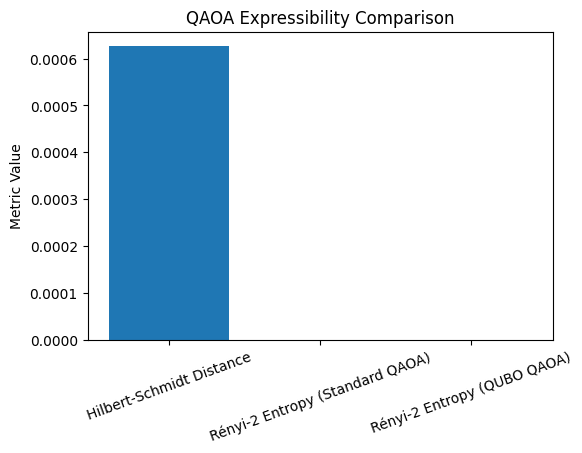

In [3]:
# Rewriting the implementation using Qiskit instead of PennyLane

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, entropy
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
import scipy

# Define QAOA ansatz using Qiskit
def qaoa_circuit(params, edges, qubo_embedding=False):
    n_qubits = len(set(sum(edges, ())))  # Number of unique qubits in the problem
    qc = QuantumCircuit(n_qubits)
    
    # Initial Hadamard layer
    qc.h(range(n_qubits))
    
    for layer in range(len(params) // 2):
        gamma, beta = params[2 * layer], params[2 * layer + 1]
        
        if qubo_embedding:
            for (i, j, w) in edges:  # Weighted QUBO embedding
                qc.cx(i, j)
                qc.rz(2 * gamma * w, j)
                qc.cx(i, j)
        else:
            for (i, j, _) in edges:
                qc.cx(i, j)
                qc.rz(2 * gamma, j)
                qc.cx(i, j)

        for i in range(n_qubits):
            qc.rx(2 * beta, i)

    return qc

# Setup simulation
simulator = AerSimulator()  

# Generate random parameters
num_layers = 3
params = np.random.uniform(0, np.pi, size=(2 * num_layers,))

# Define problem graph
edges = [(0, 1, 1.5), (1, 2, 2.0), (2, 3, 1.0), (3, 0, 1.2)]  # Weighted edges

# Run simulations
qc_standard = qaoa_circuit(params, edges, qubo_embedding=False)
qc_qubo = qaoa_circuit(params, edges, qubo_embedding=True)

# Compute statevectors
sv_standard = Statevector.from_instruction(qc_standard)
sv_qubo = Statevector.from_instruction(qc_qubo)

# Compute Hilbert-Schmidt distance
def hilbert_schmidt_distance(state1, state2):
    rho1 = np.outer(state1, np.conj(state1))
    rho2 = np.outer(state2, np.conj(state2))
    return np.trace(scipy.linalg.sqrtm(rho1) @ rho2 @ scipy.linalg.sqrtm(rho1)).real

hst_value = hilbert_schmidt_distance(sv_standard.data, sv_qubo.data)

# Compute Rényi-2 entropy
def renyi_entropy(state):
    rho = np.outer(state, np.conj(state))
    rho_squared = rho @ rho
    return -np.log2(np.trace(rho_squared))

ree_standard = renyi_entropy(sv_standard.data)
ree_qubo = renyi_entropy(sv_qubo.data)

# Plot results
fig, ax = plt.subplots(figsize=(6, 4))
bar_labels = ["Hilbert-Schmidt Distance", "Rényi-2 Entropy (Standard QAOA)", "Rényi-2 Entropy (QUBO QAOA)"]
values = [hst_value, ree_standard, ree_qubo]

ax.bar(bar_labels, values)
ax.set_ylabel("Metric Value")
ax.set_title("QAOA Expressibility Comparison")

plt.xticks(rotation=20)
plt.show()


/pscratch/sd/g/gzquse/qaoa/lib/python3.10/site-packages/matplotlib/transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


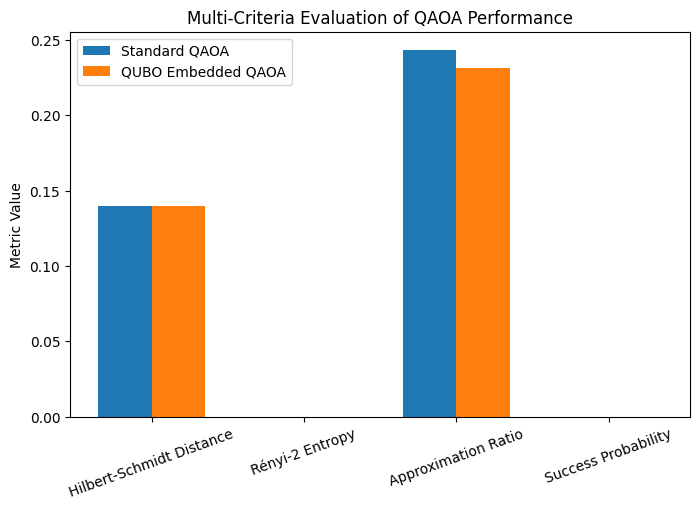

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer
from qiskit.quantum_info import Statevector
import scipy.linalg

# Define QAOA circuit
def qaoa_circuit(params, edges, qubo_embedding=False):
    n_qubits = len(set(sum(edges, ())))  # Number of qubits
    qc = QuantumCircuit(n_qubits)

    # Initial Hadamard layer
    qc.h(range(n_qubits))

    for layer in range(len(params) // 2):
        gamma, beta = params[2 * layer], params[2 * layer + 1]

        if qubo_embedding:
            for (i, j, w) in edges:
                qc.cx(i, j)
                qc.rz(2 * gamma * w, j)
                qc.cx(i, j)
        else:
            for (i, j, _) in edges:
                qc.cx(i, j)
                qc.rz(2 * gamma, j)
                qc.cx(i, j)

        for i in range(n_qubits):
            qc.rx(2 * beta, i)

    return qc

# Setup problem
edges = [(0, 1, 1.5), (1, 2, 2.0), (2, 3, 1.0), (3, 0, 1.2)]
num_layers = 3
params = np.random.uniform(0, np.pi, size=(2 * num_layers,))

# Generate circuits
qc_standard = qaoa_circuit(params, edges, qubo_embedding=False)
qc_qubo = qaoa_circuit(params, edges, qubo_embedding=True)

# Compute statevectors
sv_standard = Statevector.from_instruction(qc_standard)
sv_qubo = Statevector.from_instruction(qc_qubo)

# Hilbert-Schmidt Test
def hilbert_schmidt_distance(state1, state2):
    rho1 = np.outer(state1, np.conj(state1))
    rho2 = np.outer(state2, np.conj(state2))
    return np.trace(scipy.linalg.sqrtm(rho1) @ rho2 @ scipy.linalg.sqrtm(rho1)).real

hst_value = hilbert_schmidt_distance(sv_standard.data, sv_qubo.data)

# Rényi-2 Entropy
def renyi_entropy(state):
    rho = np.outer(state, np.conj(state))
    rho_squared = rho @ rho
    return -np.log2(np.trace(rho_squared))

ree_standard = renyi_entropy(sv_standard.data)
ree_qubo = renyi_entropy(sv_qubo.data)

# Approximation Ratio
def approximation_ratio(qc, edges):
    sv = Statevector.from_instruction(qc)
    prob_dict = sv.probabilities_dict()
    expected_energy = sum(prob * sum(int(bs[i]) * int(bs[j]) * w for (i, j, w) in edges)
                          for bs, prob in prob_dict.items())

    all_bitstrings = ['{:0{}b}'.format(i, len(edges)) for i in range(2**len(edges))]
    classical_optimum = max(sum(int(bs[i]) * int(bs[j]) * w for (i, j, w) in edges) for bs in all_bitstrings)

    return expected_energy / classical_optimum

# Success Probability
def success_probability(qc, edges):
    sv = Statevector.from_instruction(qc)
    prob_dict = sv.probabilities_dict()
    all_bitstrings = ['{:0{}b}'.format(i, len(edges)) for i in range(2**len(edges))]
    classical_optimum = max(sum(int(bs[i]) * int(bs[j]) * w for (i, j, w) in edges) for bs in all_bitstrings)
    optimal_solutions = [bs for bs in all_bitstrings if sum(int(bs[i]) * int(bs[j]) * w for (i, j, w) in edges) == classical_optimum]

    return sum(prob_dict.get(bs, 0) for bs in optimal_solutions)

# Compute metrics
approx_ratio_standard = approximation_ratio(qc_standard, edges)
approx_ratio_qubo = approximation_ratio(qc_qubo, edges)

success_prob_standard = success_probability(qc_standard, edges)
success_prob_qubo = success_probability(qc_qubo, edges)

# Prepare data for plotting
metrics = {
    "Hilbert-Schmidt Distance": [hst_value, hst_value],  # Same for both, as it's a comparison metric
    "Rényi-2 Entropy": [ree_standard, ree_qubo],
    "Approximation Ratio": [approx_ratio_standard, approx_ratio_qubo],
    "Success Probability": [success_prob_standard, success_prob_qubo]
}

labels = ["Standard QAOA", "QUBO Embedded QAOA"]

# Plot comparison
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, [metrics[key][0] for key in metrics], width, label="Standard QAOA")
ax.bar(x + width/2, [metrics[key][1] for key in metrics], width, label="QUBO Embedded QAOA")

ax.set_xticks(x)
ax.set_xticklabels(metrics.keys(), rotation=20)
ax.set_ylabel("Metric Value")
ax.set_title("Multi-Criteria Evaluation of QAOA Performance")
ax.legend()

plt.show()
